# Concours DRIVE

- Ce notebook consiste en une tâche de segmentation proposée par [GrandChallenge](https://drive.grand-challenge.org/):
--> Pour chaque image de vaisseaux sanguins, on souhaite produire un masque.
--> **Note:** on dispose de très peu de données (20~30)
--> On utilisera un modèle [Unet](https://arxiv.org/abs/1505.04597).

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import h5py
np.random.seed(42)
random.seed(42)

## Conception du U-net

In [2]:
def Unet(nbr_filters):

  # Première partie du reseau U-net (couches de convolutions)
  
  # Etage 1
  input_ = layers.Input(shape=(576, 560, 3), dtype='float32')

  output = layers.Conv2D(nbr_filters, 3, activation='relu', padding='same')(input_)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters, 3, activation='relu', padding='same')(output)
  output_1 = layers.BatchNormalization()(output)

  # Etage 2
  max_output = layers.MaxPool2D()(output_1)

  output = layers.Conv2D(nbr_filters*2, 3, activation='relu', padding='same')(max_output)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters*2, 3, activation='relu', padding='same')(output)
  output_2 = layers.BatchNormalization()(output)

  # Etage 3
  max_output = layers.MaxPool2D()(output_2)

  output = layers.Conv2D(nbr_filters*4, 3, activation='relu', padding='same')(max_output)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters*4, 3, activation='relu', padding='same')(output)
  output_3 = layers.BatchNormalization()(output)

  # Etage 4
  max_output = layers.MaxPool2D()(output_3)

  output = layers.Conv2D(nbr_filters*4, 3, activation='relu', padding='same')(max_output)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters*4, 3, activation='relu', padding='same')(output)
  output_4 = layers.BatchNormalization()(output)

  # Etage 5 (dernier étage)
  max_output = layers.MaxPool2D()(output_4)

  output = layers.Conv2D(nbr_filters*8, 3, activation='relu', padding='same')(max_output)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters*4, 3, activation='relu', padding='same')(output)
  output_5 = layers.BatchNormalization()(output)

  # Deuxième partie du U-net (Suréchantillonage et concaténation)
  
  # Etage 4
  up_output = layers.UpSampling2D()(output_5)
  concat_output = tf.concat([up_output, output_4], axis=3)

  output = layers.Conv2D(nbr_filters*8, 3, activation='relu', padding='same')(concat_output)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters*4, 3, activation='relu', padding='same')(output)
  output_4_bis = layers.BatchNormalization()(output)

  # Etage 3
  up_output = layers.UpSampling2D()(output_4_bis)
  concat_output = tf.concat([up_output, output_3], axis=3)

  output = layers.Conv2D(nbr_filters*4, 3, activation='relu', padding='same')(concat_output)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters*2, 3, activation='relu', padding='same')(output)
  output_3_bis = layers.BatchNormalization()(output)

  # Etage 2
  up_output = layers.UpSampling2D()(output_3_bis)
  concat_output = tf.concat([up_output, output_2], axis=3)

  output = layers.Conv2D(nbr_filters*2, 3, activation='relu', padding='same')(concat_output)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters, 3, activation='relu', padding='same')(output)
  output_2_bis = layers.BatchNormalization()(output)

  # Etage 1
  up_output = layers.UpSampling2D()(output_2_bis)
  concat_output = tf.concat([up_output, output_1], axis=3)

  output = layers.Conv2D(nbr_filters, 3, activation='relu', padding='same')(concat_output)
  output = layers.BatchNormalization()(output)
  output = layers.Conv2D(nbr_filters, 3, activation='relu', padding='same')(output)
  output_1_bis = layers.BatchNormalization()(output)

  # Sortie finale
  final_output = layers.Conv2D(1, 1, activation='sigmoid', padding='same')(output_1_bis)

  model = models.Model(inputs=input_, outputs=final_output)

  return model

## Augmentation des données

#### Fonctions d'augmentation 

In [3]:
def rotateImage(image, angle):
    image_center=tuple(np.array(image.shape[1::-1])/2) # [1::-1]---> interversion de la hauteur et largeur pour cv2
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rotated = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return rotated

def noise(image):
    h, w, c = image.shape
    noise = np.random.randn(h, w, c)*random.randint(5, 30)
    return np.clip(image+noise, 0, 255).astype(np.uint8)

def affine_transformation(image, alpha=1.0, beta=0.0):
    return np.clip(alpha*image+beta, 0, 255).astype(np.uint8)

def color(image, alpha=20):
    pixel_variation = [random.randint(-alpha, alpha), random.randint(-alpha, alpha),random.randint(-alpha, alpha)]
    return np.clip(image+pixel_variation, 0, 255).astype(np.uint8)

def random_transformation(image):
    if np.random.randint(2):
        image = affine_transformation(image, random.uniform(0.8, 1.2), np.random.randint(-50, 50))
    if np.random.randint(2):
       image = noise(image)
    if np.random.randint(2):
        image = color(image)
    return image

#### Phase d'augmentation

--> Accès aux données

In [4]:
# Import de PIL.Image pour les autres formats
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from PIL import Image
import os

In [5]:
#drive.mount('/content/drive') #---> pour que colab accède au Drive
TRAIN_PATH = '/content/drive/MyDrive/HollowOak/Concours DRIVE/training/images/'
MASK_PATH = '/content/drive/MyDrive/HollowOak/Concours DRIVE/training/1st_manual/'
TEST_PATH = '/content/drive/MyDrive/HollowOak/Concours DRIVE/test/images/'

--> Conversion des données en numpy.array et traitement d'image

In [ ]:
train_images=[]
masks=[]

files_training_img = os.listdir(TRAIN_PATH)
    
for file_ in files_training_img:
    # Récupération d'une image du trainset (format .tif)
    img_orig = cv2.imread(TRAIN_PATH + file_)
    number = file_.split('_')[0]                       # --> numéro de l'image
    train_images.append(img_orig[:576, :560])          # ---> supp des pixels non necessaires 
    # Récupération du mask correspondant (format .gif)
    file_mask = MASK_PATH + number + '_manual1.gif'
    mask_orig = np.array(Image.open(file_mask))
    masks.append(mask_orig[:576, :560])

    ### Aplication des fonctions de tranformations aux données
    for angle in range(0, 360, 30):
        
        rotated_img = rotateImage(img_orig, angle)
        
        img = random_transformation(rotated_img)
        train_images.append(img[:576, :560])
        mask_rotated = rotateImage(mask_orig, angle)
        masks.append(mask_rotated[:576, :560])

        img = cv2.flip(rotated_img, 0)
        img = random_transformation(img)
        train_images.append(img[:576, :560])
        fliped_mask = cv2.flip(mask_rotated, 0)
        masks.append(fliped_mask[:576, :560])

        img = cv2.flip(rotated_img, 1)
        img = random_transformation(img)
        train_images.append(img[:576, :560])
        fliped_mask = cv2.flip(mask_rotated, 1)
        masks.append(fliped_mask[:576, :560])

        img = cv2.flip(rotated_img, -1)
        img = random_transformation(img)
        train_images.append(img[:576, :560])
        fliped_mask = cv2.flip(mask_rotated, -1)
        masks.append(fliped_mask[:576, :560])

--> Sauvegarde des données générées (optionnel)

In [27]:
# Sauvegarde des données
DRIVE_PATH = '/content/drive/MyDrive/HollowOak/Concours DRIVE/'
os.chdir(DRIVE_PATH)
h5f = h5py.File('data.h5', 'w')
h5f.create_dataset('train_images', data=train_images)
h5f.create_dataset('masks', data=masks)
h5f.close()

In [28]:
# Restauration des données
data = h5py.File('data.h5', 'r')
train_images = data['train_images']
masks = data['masks']

In [63]:
print('Shape')
print(' train_images:', train_images.shape)
print(' masks:', masks.shape)

Shape
 train_images: (980, 576, 560, 3)
 masks: (980, 576, 560)


#### Aperçu des données

-->  Fonction d'affichage 

In [39]:
def Affichage(indice):
  fig = plt.figure(figsize=(12, 8))
  fig.patch.set_facecolor('0.2')
  fig.subplots_adjust(hspace=0.1)
  plt.subplot(1, 2, 1)
  plt.axis('off')
  plt.imshow(train_images[indice][:, :, ::-1])
  plt.subplot(1, 2, 2)
  plt.axis('off')
  plt.imshow(255 - masks[indice], cmap='binary')
  plt.show()

--> Visualisation

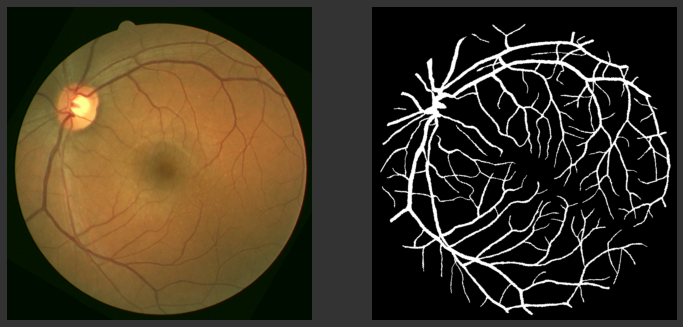

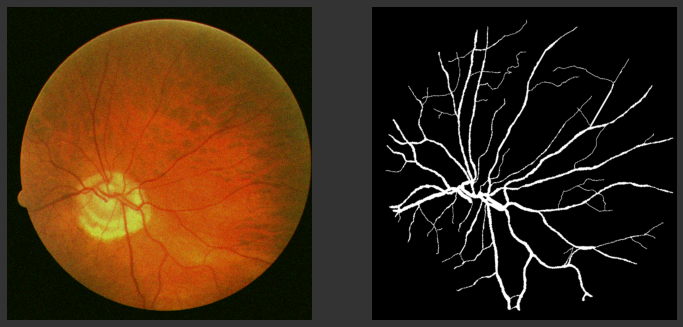

In [83]:
# Quelques images\masques
for i in [128, 704]:
  Affichage(i)

## Finalisation du jeu de données

#### Train Test Split



In [13]:
train_images = np.array(train_images, dtype=np.float32)/255
masks = np.array(masks, dtype=np.float32)/255

# Concevoir son jeu train/valid à partir d'un set généré principalement par une phase d'augmentation
# importante des données, n'est pas une bonne idée: 
# Beaucoup de redondance = évaluation peu fiable (mais on va le faire comme même)
train_img, valid_images, train_masks, valid_masks = train_test_split(train_images, masks, test_size=0.05)

del train_images
del masks

#### Perte adaptée à la tâche

In [14]:
def LossDice(y_true, y_pred):
  numerateur = tf.reduce_sum(y_true*y_pred, axis=(1, 2))
  denominateur = tf.reduce_sum(y_true + y_pred, axis=(1, 2))
  dice = 2 * numerateur / (denominateur + 1E-4)
  return 1 - dice

## Entrainement du modèle

In [15]:
model = Unet(64)

model.compile(optimizer='adam',
              loss=LossDice,
              metrics=['accuracy'])

model.fit(train_img,
          train_masks,
          epochs=20,
          batch_size=4,
          validation_data=(valid_images, valid_masks))

Epoch 1/20
233/233 [==============================] - 280s 975ms/step - loss: 0.5637 - accuracy: 0.7550 - val_loss: 0.9634 - val_accuracy: 0.8742
Epoch 2/20
233/233 [==============================] - 207s 886ms/step - loss: 0.3066 - accuracy: 0.9160 - val_loss: 0.5542 - val_accuracy: 0.8878
Epoch 3/20
233/233 [==============================] - 207s 887ms/step - loss: 0.2717 - accuracy: 0.9216 - val_loss: 0.2807 - val_accuracy: 0.9274
Epoch 4/20
233/233 [==============================] - 207s 887ms/step - loss: 0.2600 - accuracy: 0.9233 - val_loss: 0.2675 - val_accuracy: 0.9271
Epoch 5/20
233/233 [==============================] - 207s 887ms/step - loss: 0.2545 - accuracy: 0.9242 - val_loss: 0.2755 - val_accuracy: 0.9269
Epoch 6/20
233/233 [==============================] - 207s 887ms/step - loss: 0.2485 - accuracy: 0.9252 - val_loss: 0.2774 - val_accuracy: 0.9244
Epoch 7/20
233/233 [==============================] - 207s 889ms/step - loss: 0.2409 - accuracy: 0.9273 - val_loss: 0.2740 -

In [64]:
# Sauvegarde des poids
DRIVE_PATH = '/content/drive/MyDrive/HollowOak/Concours DRIVE/'
os.chdir(DRIVE_PATH)
# model.save_weights(DRIVE_PATH)

In [ ]:
# Restauration des poids
#model = Unet(64)
#model.load_weights(DRIVE_PATH)

## Prédictions

--> Lecture des données de test

In [16]:
test_images = []
test_ids=[]
for file_ in os.listdir(TEST_PATH):
    img = cv2.imread(TEST_PATH+file_)
    test_images.append(img[:576, :560])
    test_ids.append(file_.split('_')[0])

test_images = np.array(test_images, dtype=np.float32)/255
test_ids = np.array(test_ids)

--> Inférence sur le jeu de test et sauvegarde

In [17]:
# Chemin de sauvegarde
PREDICTIONS_PATH = '/content/drive/MyDrive/HollowOak/Concours DRIVE/Predictions/'
os.chdir(PREDICTIONS_PATH)

In [18]:
for id in range(len(test_images)):
    final_mask = np.zeros((584, 565, 1), dtype=np.float32)
    prediction = model.predict(np.array([test_images[id]]))
    final_mask[:576, :560] = prediction[0]*255
    # Sauvegarde
    cv2.imwrite(PREDICTIONS_PATH + str(test_ids[id]) + ".png", final_mask)

## Visualisation 

In [19]:
# Remise à l'échelle
test_images = test_images*255
test_images = np.array(test_images, dtype=int)
# Chemins des prédictions
name_predictions = ['./{}.png'.format(i) for i in test_ids]

In [67]:
# Lecture des prédictions
predictions = []
for name in name_predictions:
  pred = cv2.imread(PREDICTIONS_PATH + name)
  predictions.append(pred)
predictions = np.array(predictions)

In [75]:
print('Predictions:', predictions.shape)

Predictions: (20, 584, 565, 3)


In [94]:
def Affichage_pred(indice):
  fig = plt.figure(figsize=(14, 8))
  fig.patch.set_facecolor('0.2')
  fig.subplots_adjust(hspace=0.1)
  plt.subplot(1, 2, 1)
  plt.axis('off')
  plt.imshow(test_images[indice][:, :, ::-1])
  plt.subplot(1, 2, 2)
  plt.axis('off')
  plt.imshow(predictions[indice])
  plt.show()

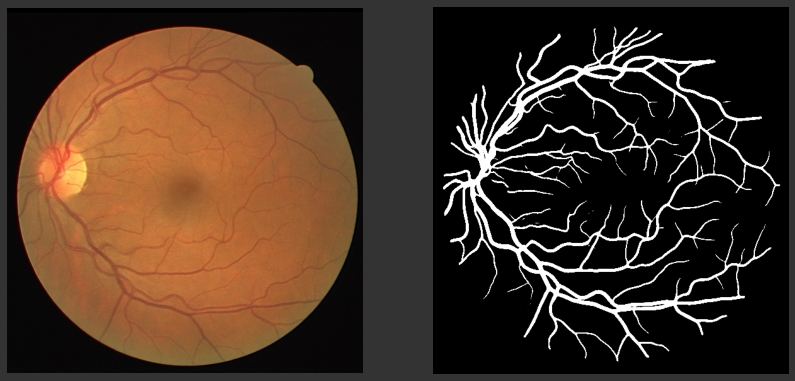

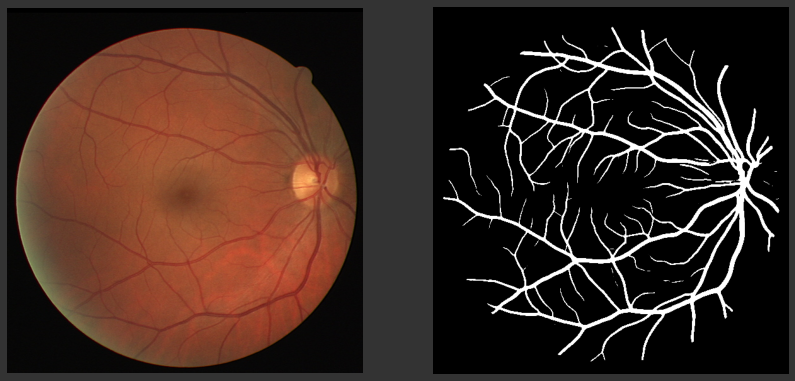

In [96]:
for i in [1, 13]:
  Affichage_pred(i)

- Fin de notebook